In [30]:
import numpy as np
import torch
import torchvision
import os
import matplotlib.pyplot as plt
import time
import scipy.io as sio
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import copy


## Configs

In [31]:
np.random.seed(42)

num_workers = 2
sets_sizes = {'train' : 0.5,
              'val' : 0.25,
              'test' : 0.25}
batch_size = 16
edge_size = 224 
output_size = 102
epochs_num = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device.type)

cpu


## loading 102flowers dataset

In [32]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(1, 1.1)), # bilinear interpolation
    transforms.Resize(256, interpolation=2), 
    transforms.CenterCrop(edge_size),
])

dataset = torch.utils.data.ConcatDataset([datasets.Flowers102(root='./data', download=True, split='train', transform=transform), 
                                          datasets.Flowers102(root='./data', download=True, split='val', transform=transform), 
                                          datasets.Flowers102(root='./data', download=True, split='test', transform=transform)])
print(len(dataset))



8189


C:\Users\nirba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


## splitting the train data to train and validation

In [33]:
# split the data into training and validation sets using torch.utils.data.random_split
train_size = int(sets_sizes['train'] * len(dataset))
val_size = int(sets_sizes['val'] * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

## creating dataloader for train, validation and test

In [34]:
class GpuDataLoader:
    def __init__(self, dl):
        self.dl = dl

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        return map(lambda batch: (batch[0].to(device), batch[1].to(device)), self.dl)

In [35]:
# creating dataloader for train, validation and test
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

if device.type == 'cuda':
    train_loader = GpuDataLoader(train_loader)
    val_loader = GpuDataLoader(val_loader)
    test_loader = GpuDataLoader(test_loader)

## visualizing several images from the train_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch of images shape:  torch.Size([16, 3, 224, 224])
batch of labels shape:  torch.Size([16])


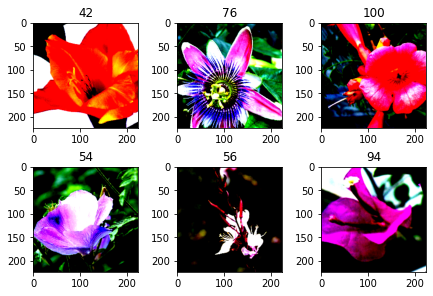

In [36]:
# get a single batch
dataiter = iter(train_loader)
images, labels = next(dataiter)
print("batch of images shape: ", images.shape)
print("batch of labels shape: ", labels.shape)

# show batch 6 first images
fig, axs = plt.subplots(2, 3, constrained_layout=True)
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(images[idx].cpu().numpy().transpose((1, 2,0)))
    ax.set_title(str(labels[idx].item()))

## training and score calculation

In [37]:
def calc_acc(model, set='train'):
  if set == 'train':
      loader = train_loader
  elif set == 'val':
      loader = val_loader
  elif set == 'test':
      loader = test_loader
  else:
      raise ValueError('set must be one of train, val, test')

  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in loader:

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.shape[0]
      correct += (predicted == labels).sum().item()
  return correct / total

def calc_loss(model, set='train'):
  if set == 'train':
    loader = train_loader
  elif set == 'val':
    loader = val_loader
  elif set == 'test':
    loader = test_loader
  else:
    raise ValueError('set must be one of train, val, test')

  loss = 0
  with torch.no_grad():
    for images, labels in loader:
      outputs = model(images)
      loss += F.cross_entropy(outputs, labels)
  return loss / len(loader)

In [38]:
def train_model(model, epochs_num=30, lr=0.001, log_dir=None):
  writer = SummaryWriter(log_dir=log_dir)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  for epoch in tqdm(range(epochs_num)):
    for idx, batch in enumerate(train_loader):
      X, y = batch

      output = model(X)
      loss = criterion(output, y)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # log the losses and accuracy after every epoch
    writer.add_scalar('Loss/train', calc_loss(model, set='train'), epoch)
    writer.add_scalar('Loss/val', calc_loss(model, set='val'), epoch)
    writer.add_scalar('Accuracy/train', calc_acc(model, set='train'), epoch)
    writer.add_scalar('Accuracy/val', calc_acc(model, set='val'), epoch)
    writer.flush()

    # save model checkpoints after every epoch
    torch.save(model.state_dict(), os.path.join(log_dir, 'model_epoch_{}.pt'.format(epoch)))

  writer.close()

## Running nets

In [39]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import resnet18, ResNet18_Weights

def get_mobilenet(freeze_layers):
    mnet_pt = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2)
    model = copy.deepcopy(mnet_pt)
    if freeze_layers:
        for param in model.parameters():
            param.requires_grad = False
    model.classifier[-1] = nn.Linear(in_features=1280, out_features=output_size)
    model.to(device)    
    return model

def get_densenet(freeze_layers):
    densenet_pt = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
    model = copy.deepcopy(densenet_pt)
    if freeze_layers:
        for param in model.parameters():
            param.requires_grad = False
    model.classifier = nn.Linear(model.classifier.in_features, output_size)
    model = model.to(device)
    return model

def get_resnet(freeze_layers):
    resnet_pt = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model = copy.deepcopy(resnet_pt)
    if freeze_layers:
        for param in model.parameters():
            param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, output_size)
    model = model.to(device)
    return model

#### MobileNet_V3 - finetune model

In [40]:
PATH = './models/mobilenet.pt'
model = get_mobilenet(freeze_layers=False)

if not os.path.exists(PATH):
    train_model(model, epochs_num=15, lr=5e-4, log_dir='./runs/mobilenet')
    torch.save(model.state_dict(), PATH)
else:
    model.load_state_dict(torch.load(PATH, map_location=device))

print(f"The test accuracy of the mobileNet (finetune) model is: {calc_acc(model, set='test')*100:.2f} %")

The test accuracy of the mobileNet (finetune) model is: 95.65 %


#### MobileNet_V3 - feature extractor model

In [41]:
PATH = './models/mobilenetfreeze.pt'
model = get_mobilenet(freeze_layers=True)

if not os.path.exists(PATH):
    train_model(model, epochs_num=15, lr=5e-4, log_dir='./runs/mobilenetfreeze')
    torch.save(model.state_dict(), PATH)
else:
    model.load_state_dict(torch.load(PATH, map_location=device))

print(f"The test accuracy of the mobileNet (feature extractor) model is: {calc_acc(model, set='test')*100:.2f} %")

The test accuracy of the mobileNet (feature extractor) model is: 92.29 %


#### DenseNet121 - finetune model

In [44]:
PATH = './models/densenet121.pt'
model = get_densenet(freeze_layers=False)

if not os.path.exists(PATH):
    train_model(model, epochs_num=15, lr=5e-4, log_dir='./runs/densenet121')
    torch.save(model.state_dict(), PATH)
else:
    model.load_state_dict(torch.load(PATH, map_location=device))

print(f"The test accuracy of the DenseNet (finetune) model is: {calc_acc(model, set='test')*100:.2f} %")

The test accuracy of the DenseNet (finetune) model is: 92.14 %


#### DenseNet121 - feature extractor model

In [45]:
PATH = './models/densenet121freeze.pt'
model = get_densenet(freeze_layers=True)

if not os.path.exists(PATH):
    train_model(model, epochs_num=15, lr=5e-4, log_dir='./runs/densenet121freeze')
    torch.save(model.state_dict(), PATH)
else:
    model.load_state_dict(torch.load(PATH, map_location=device))

print(f"The test accuracy of the DenseNet (feature extractor) model is: {calc_acc(model, set='test')*100:.2f} %")

The test accuracy of the DenseNet (feature extractor) model is: 93.31 %


#### ResNet18 - finetune model

In [46]:
PATH = './models/resnet18.pt'
model = get_resnet(freeze_layers=True)

if not os.path.exists(PATH):
    train_model(model, epochs_num=15, lr=5e-4, log_dir='./runs/resnet18')
    torch.save(model.state_dict(), PATH)
else:
    model.load_state_dict(torch.load(PATH, map_location=device))

print(f"The test accuracy of the ResNet (feature extractor) model is: {calc_acc(model, set='test')*100:.2f} %")

The test accuracy of the ResNet (feature extractor) model is: 90.04 %
